Effects of Diamond Characteristics on Their Prices
===

**Dr Chao Shu (chao.shu@qmul.ac.uk)**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_theme(style="ticks")

# Set the random seed for reproducibility
np.random.seed(42)

# suppress warnings from final output
# import warnings
# warnings.simplefilter("ignore")

## Investigation Overview

In this investigation, I wanted to look at the characteristics of diamonds that could be used to predict their prices. The main focus was on the four Cs of diamonds: carat (weight), cut grade, color grade, and clarity grade.

## Dataset Overview

The data consisted of prices and attributes of approximately 54,000 round-cut diamonds. The attributes included the four Cs of diamonds, as well as additional measurements such as table, depth, and dimensions. Thirty-nine data points were removed from the analysis due to inconsistencies or missing information.

In [2]:
# load in the dataset into a pandas dataframe
diamonds_df = pd.read_csv('datasets/T04_diamonds.csv')

In [3]:
# data wrangling, removing diamonds with inconsistent or missing data.
incorrect_depth = (np.abs(2 * diamonds_df['z'] / (diamonds_df['x'] + diamonds_df['y']) - diamonds_df['depth']/100) > 0.1)
no_size_info = ((diamonds_df['x'] == 0) & (diamonds_df['y'] == 0))
diamonds_df = diamonds_df[~incorrect_depth & ~no_size_info]

In [4]:
# convert cut, color, and clarity into ordered categorical types
ordinal_var_dict = {'cut': ['Fair','Good','Very Good','Premium','Ideal'],
                    'color': ['J', 'I', 'H', 'G', 'F', 'E', 'D'],
                    'clarity': ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered=True,
                                                categories=ordinal_var_dict[var])
    diamonds_df[var] = diamonds_df[var].astype(ordered_var)

## Distribution of Diamond Prices

Diamond prices in the dataset take on a very large range of values, from about \\$300 at the lowest, to about \$19,000 at the highest. Plotted on a logarithmic scale, the distribution of diamond prices shows a multimodal shape.

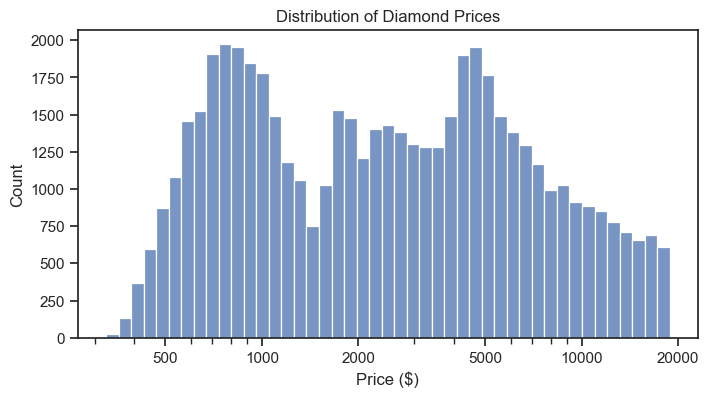

In [5]:
# univariate plot of diamond prices
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(data=diamonds_df, x='price', log_scale=10, ax=ax)

# Generate the x-ticks you want to apply
ticks = [500, 1000, 2000, 5000, 10000, 20000]
# Convert ticks into string values, to be displayed along the x-axis
labels = ['{}'.format(v) for v in ticks]

ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_xlabel('Price ($)')
ax.set_title('Distribution of Diamond Prices')

plt.show()

## Distribution of Carat Weights

Carat is a measure of a diamond's weight, where 1 carat is equivalent to 0.2 grams. A large proportion of diamonds have carat sizes to one decimal place (e.g. 0.3, 0.7, 1.0) or slightly larger, with gradually decreasing frequencies until the next peak is reached.

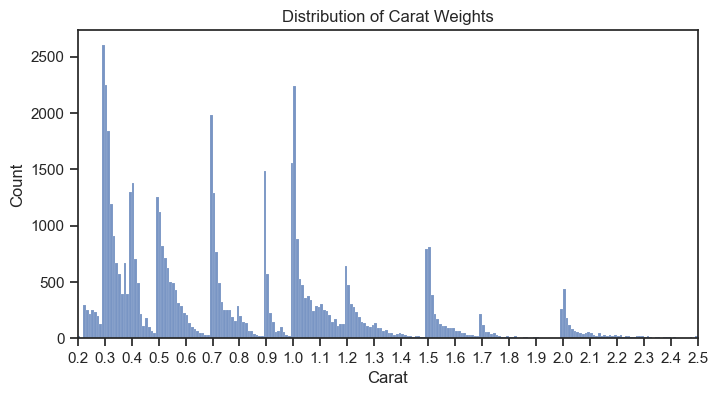

In [6]:
binsize = 0.01

fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(data=diamonds_df, x='carat', binwidth=binsize, ax=ax)

ax.set_xlim([diamonds_df['carat'].min(), 2.5])
ax.set_xticks(np.arange(0.2, 2.5+0.1, 0.1))
ax.set_xlabel('Carat')
ax.set_title('Distribution of Carat Weights')

plt.show()

## Price vs. Diamond Size

Plotting price on a logarithmic scale and taking the cube root of carat (which is approximately proportional to the dimensions of the diamond) produces an approximately linear relationship. For carat weights above 1.5, there appears to be a price ceiling: based on the trend below 1.5 carats, we might expect some larger diamonds to take prices higher than \$20,000.

In [7]:
# compute cube root of carat for modeling and plotting
def cuberoot_trans(x, inverse=False):
    """ quick function for computing cube root and cube operations """
    if not inverse:
        return x ** (1/3)
    else:
        return x ** 3

diamonds_df['cr_carat'] = diamonds_df['carat'].apply(cuberoot_trans)

In [8]:
# compute the logarithm of price to make multivariate plotting easier
def log_trans(x, inverse=False):
    """ quick function for computing log and power operations """
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)

diamonds_df['log_price'] = diamonds_df['price'].apply(log_trans)

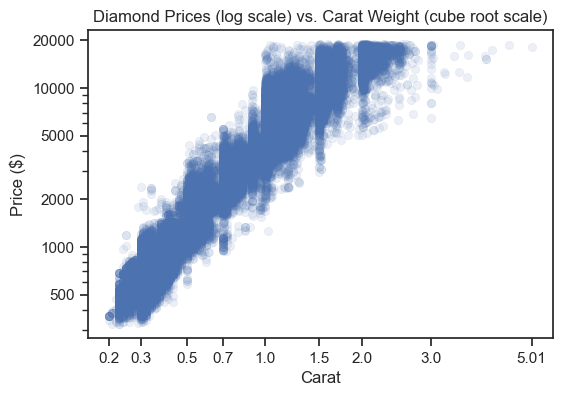

In [9]:
# scatter plot of price vs. carat, with log transform on price axis and
# cube-root transform on price
fig, ax = plt.subplots(figsize=(6, 4))

sns.scatterplot(data=diamonds_df, x='cr_carat', y='price', ax=ax, alpha=0.1, ec='face')

# Generate the y-ticks you want to apply
yticks = [500, 1000, 2000, 5000, 10000, 20000]
# Convert ticks into string values, to be displayed along the y-axis
ylabels = ['{}'.format(v) for v in yticks]

# Generate the x-ticks you want to apply
carat_ticks = np.array([0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3, 5.01])
xticks = cuberoot_trans(carat_ticks)
# Convert ticks into string values, to be displayed along the x-axis
xlabels = ['{}'.format(v) for v in carat_ticks]

ax.set_yscale('log')
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.set_xlabel('Carat')
ax.set_ylabel('Price ($)')
ax.set_title('Diamond Prices (log scale) vs. Carat Weight (cube root scale)')

plt.show()

## Price and Diamond Size by Clarity Grade

There is an interaction effect visible between price, diamond size, and the categorical measures of quality: cut, color, and clarity. This is most evident for the clarity measure. As clarity grade increases from the lowest of I1 to the highest at IF, there are much fewer diamonds of size around 1 carat, and many more diamonds of size around 0.3 carats. At the same time, you can see an increase in one peak from around \$3,000 to \$10,000, and a second peak from about \$500 to \$1,000, whose sizes seem to correspond with the changes in carat weight. This accounts for the base observation that price tends to decrease with increased quality, because the diamonds with higher quality also tend to be smaller in size.

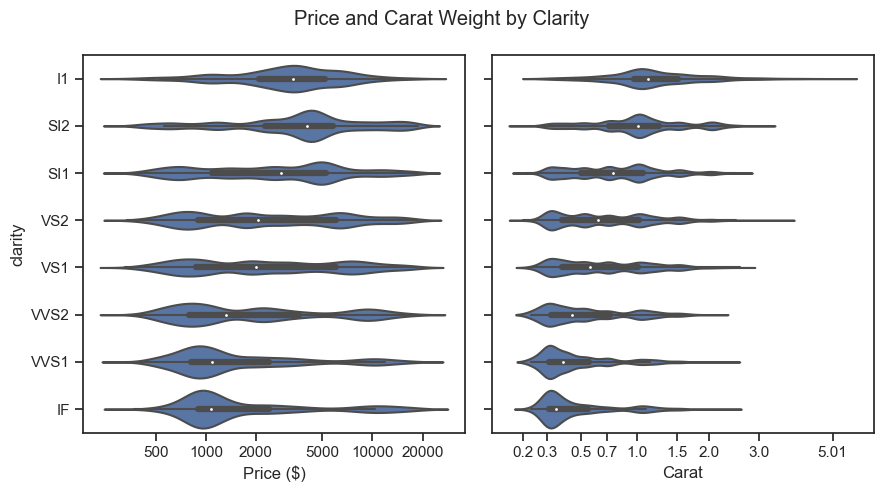

In [10]:
# plot the categorical variables against price and carat again, this time
# with full data and variable transforms
fig, axs = plt.subplots(ncols=2, figsize=[9, 5], sharey=True)

# Generate the y-ticks you want to apply
price_ticks = np.array([500, 1000, 2000, 5000, 10000, 20000])
# Corresponding ticks for values in the 'log_price' column
log_price_ticks = log_trans(price_ticks)
# Convert ticks into string values, to be displayed along the y-axis
price_labels = ['{}'.format(v) for v in price_ticks]
# Generate the y-ticks you want to apply
carat_ticks = np.array([0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3, 5.01])
# Corresponding ticks for values in the 'cr_carat' column
cr_carat_ticks = cuberoot_trans(carat_ticks)
# Convert ticks into string values, to be displayed along the y-axis
carat_labels = ['{}'.format(v) for v in carat_ticks]

default_color = sns.color_palette()[0]
sns.violinplot(data=diamonds_df, x='log_price', y='clarity', ax=axs[0], color=default_color)
axs[0].set_xticks(log_price_ticks)  # Because we use 'log_price' column
axs[0].set_xticklabels(price_labels)  # Show the corresponding actual price
axs[0].set_xlabel('Price ($)')  # y-axis shows the actual price
sns.violinplot(data=diamonds_df, x='cr_carat', y='clarity', ax=axs[1], color=default_color)
axs[1].set_xticks(cr_carat_ticks)
axs[1].set_xticklabels(carat_labels)
axs[1].set_ylabel('')
axs[1].set_xlabel('Carat')  # y-axis shows the actual carat

fig.suptitle('Price and Carat Weight by Clarity')
fig.tight_layout()
plt.show()

## Price by Color and Clarity for Selected Carat Weights

We can see how color and clarity grades affect diamond price by plotting the average price on selected carat weights: those around 0.3 carats and those around 1 carat. For both the 0.3-carat and 1.0-carat diamonds, as the clarity level increases, the general height of the points rises, showing an increase in price. Within each level of clarity, we also observe an increase in price based on the color grade (J is lowest, D is highest).

In [11]:
# select diamonds of about 1 carat and 0.3 carat.
diamonds_1carat_df = diamonds_df.query('carat >= 0.99 and carat <= 1.03')
diamonds_small_df = diamonds_df.query('carat >= 0.29 and carat <= 0.33')

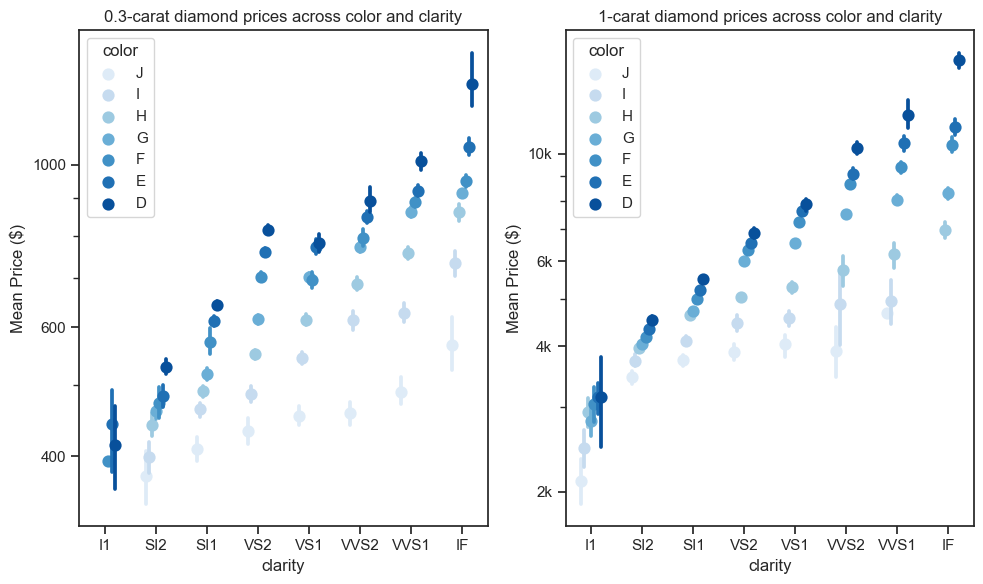

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=[10, 6])

sns.pointplot(data=diamonds_small_df, x='clarity', y='price', hue='color',
             palette='Blues', join=False, dodge = 0.4, ax=axs[0])
axs[0].set_title('0.3-carat diamond prices across color and clarity')
axs[0].set_ylabel('Mean Price ($)')
axs[0].set_yscale('log')
axs[0].set_yticks([400, 600, 1000])
axs[0].set_yticklabels(['400', '600', '1000'])

sns.pointplot(data=diamonds_1carat_df, x='clarity', y='price', hue='color',
             palette='Blues', join=False, dodge = 0.4, ax=axs[1])
axs[1].set_title('1-carat diamond prices across color and clarity')
axs[1].set_ylabel('Mean Price ($)')
axs[1].set_yscale('log')
axs[1].set_yticks([2000, 4000, 6000, 10000])
axs[1].set_yticklabels(['2k', '4k', '6k', '10k'])

fig.tight_layout()
plt.show()

## Price by Cut and Clarity for Selected Carat Weights

Reproducing the same plots with cut instead of color grade shows that pricing increases with cut quality grade as well. However, it appears that the overall effect of cut is smaller (from worst to best) when compared with color.

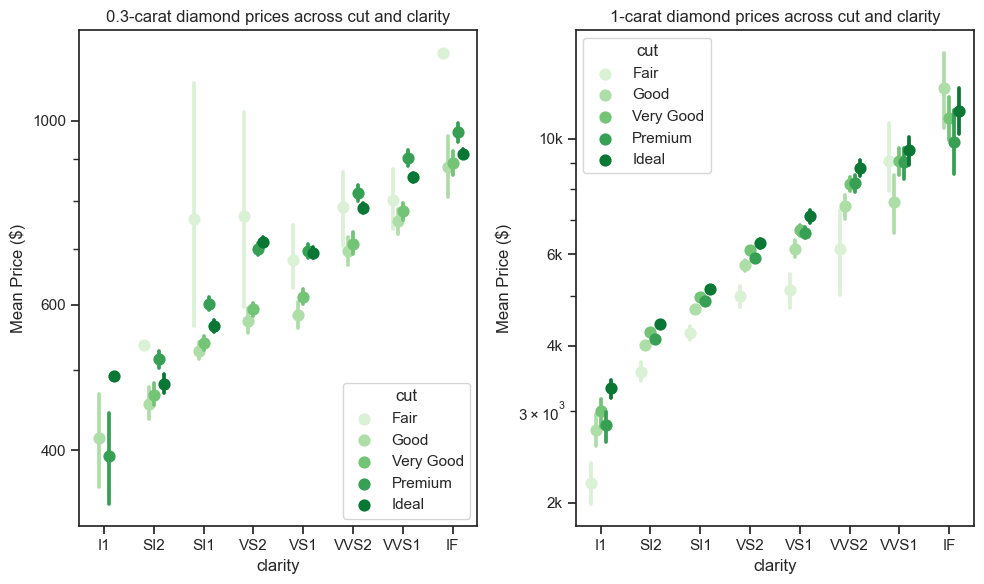

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=[10, 6])

sns.pointplot(data=diamonds_small_df, x='clarity', y='price', hue='cut',
             palette='Greens', join=False, dodge = 0.4, ax=axs[0])
axs[0].set_title('0.3-carat diamond prices across cut and clarity')
axs[0].set_ylabel('Mean Price ($)')
axs[0].set_yscale('log')
axs[0].set_yticks([400, 600, 1000])
axs[0].set_yticklabels(['400', '600', '1000'])

sns.pointplot(data=diamonds_1carat_df, x='clarity', y='price', hue='cut',
             palette='Greens', join=False, dodge = 0.4, ax=axs[1])
axs[1].set_title('1-carat diamond prices across cut and clarity')
axs[1].set_ylabel('Mean Price ($)')
axs[1].set_yscale('log')
axs[1].set_yticks([2000, 4000, 6000, 10000])
axs[1].set_yticklabels(['2k', '4k', '6k', '10k'])

fig.tight_layout()
plt.show()